### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.5)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score


import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer

import warnings
warnings.filterwarnings('ignore')

import pickle
from pickle import dump, load

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

np.random.seed = 0

### Data Exploration

In [2]:
df = pd.read_csv("weather0.csv", parse_dates=['timestamp'],index_col=['timestamp'])

In [3]:
df

,TimeMST,TemperatureC,DewPointC,Humidity,SeaLevelPressurehPa,VisibilityKm,WindDirection,WindSpeedKmh,GustSpeedKmh,Precipitationmm,Events,Conditions,WindDirDegrees
timestamp,,,,,,,,,,,,,
2015-01-01 00:51:00,12:51 AM,2.8,-0.6,79.0,1016.0,16.1,WNW,9.3,NaN,NaN,NaN,Mostly Cloudy,300
2015-01-01 01:47:00,1:47 AM,3.0,-1.0,75.0,1016.5,16.1,WNW,5.6,NaN,NaN,NaN,Mostly Cloudy,300
2015-01-01 01:51:00,1:51 AM,2.8,-0.6,79.0,1016.9,16.1,WNW,7.4,NaN,NaN,NaN,Mostly Cloudy,300
2015-01-01 02:51:00,2:51 AM,2.8,-1.1,76.0,1017.2,16.1,NW,5.6,NaN,NaN,NaN,Scattered Clouds,320
2015-01-01 03:51:00,3:51 AM,2.2,-0.6,82.0,1017.5,16.1,ENE,5.6,NaN,NaN,NaN,Partly Cloudy,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31 19:51:00,7:51 PM,12.2,-6.1,28.0,1016.6,16.1,West,11.1,NaN,NaN,NaN,Clear,280
2015-12-31 20:51:00,8:51 PM,11.7,-6.7,27.0,1017.0,16.1,West,11.1,NaN,NaN,NaN,Partly Cloudy,270
2015-12-31 21:51:00,9:51 PM,10.0,-6.7,31.0,1017.2,16.1,West,5.6,NaN,NaN,NaN,Clear,260


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8999 entries, 2015-01-01 00:51:00 to 2015-12-31 23:51:00
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   TimeMST              8999 non-null   object 
 1   TemperatureC         8999 non-null   float64
 2   DewPointC            8999 non-null   float64
 3   Humidity             8990 non-null   float64
 4   SeaLevelPressurehPa  8999 non-null   float64
 5   VisibilityKm         8999 non-null   float64
 6   WindDirection        8999 non-null   object 
 7   WindSpeedKmh         8999 non-null   object 
 8   GustSpeedKmh         6370 non-null   object 
 9   Precipitationmm      443 non-null    float64
 10  Events               330 non-null    object 
 11  Conditions           8999 non-null   object 
 12  WindDirDegrees       8999 non-null   int64  
dtypes: float64(6), int64(1), object(6)
memory usage: 984.3+ KB


In [5]:
df.describe(include='all')

,TimeMST,TemperatureC,DewPointC,Humidity,SeaLevelPressurehPa,VisibilityKm,WindDirection,WindSpeedKmh,GustSpeedKmh,Precipitationmm,Events,Conditions,WindDirDegrees
count,8999,8999.000000,8999.000000,8990.000000,8999.000000,8999.000000,8999,8999,6370,443.000000,330,8999,8999.000000
unique,267,NaN,NaN,NaN,NaN,NaN,18,33,34,NaN,4,18,NaN
top,1:51 PM,NaN,NaN,NaN,NaN,NaN,East,Calm,-,NaN,Rain,Mostly Cloudy,NaN
freq,365,NaN,NaN,NaN,NaN,NaN,1491,1268,5762,NaN,175,2528,NaN
mean,NaN,14.744705,-4.294922,35.108676,1011.341182,3.680398,NaN,NaN,NaN,0.034379,NaN,NaN,140.644516
std,NaN,316.995945,316.353832,20.269304,4.899539,349.952158,NaN,NaN,NaN,0.081561,NaN,NaN,106.330864
min,NaN,-9999.000000,-9999.000000,4.000000,997.200000,-9999.000000,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000
25%,NaN,17.200000,-0.600000,20.000000,1007.800000,16.100000,NaN,NaN,NaN,0.000000,NaN,NaN,70.000000
50%,NaN,25.000000,5.600000,31.000000,1010.600000,16.100000,NaN,NaN,NaN,0.000000,NaN,NaN,120.000000
75%,NaN,32.200000,12.200000,46.000000,1014.400000,16.100000,NaN,NaN,NaN,0.030000,NaN,NaN,240.000000


In [6]:
df.shape

(8999, 13)

In [7]:
df.columns

Index(['TimeMST', 'TemperatureC', 'DewPointC', 'Humidity',
       'SeaLevelPressurehPa', 'VisibilityKm', 'WindDirection', 'WindSpeedKmh',
       'GustSpeedKmh', 'Precipitationmm', 'Events', 'Conditions',
       'WindDirDegrees'],
      dtype='object')

### Data Exploration

In [8]:
df['TemperatureC'].value_counts()

30.0    197
32.2    195
31.7    190
22.8    185
13.9    184
       ... 
39.0      1
46.7      1
42.0      1
46.0      1
3.0       1
Name: TemperatureC, Length: 114, dtype: int64

In [9]:
df['TemperatureC'].sort_values()

timestamp
2015-01-09 03:51:00   -9999.0
2015-01-09 02:51:00   -9999.0
2015-01-09 01:51:00   -9999.0
2015-01-09 04:51:00   -9999.0
2015-01-09 00:51:00   -9999.0
                        ...  
2015-06-18 14:51:00      45.6
2015-08-15 16:51:00      45.6
2015-06-19 14:51:00      46.0
2015-08-14 15:51:00      46.7
2015-06-27 18:51:00      50.0
Name: TemperatureC, Length: 8999, dtype: float64

In [10]:
df['DewPointC'].value_counts()

 3.3     242
 1.1     239
 2.8     226
 2.2     225
 5.0     220
        ... 
 11.0      1
 18.7      1
 23.3      1
-17.8      1
-7.0       1
Name: DewPointC, Length: 104, dtype: int64

In [11]:
df['DewPointC'].sort_values()

timestamp
2015-08-31 23:16:00   -9999.0
2015-01-09 02:51:00   -9999.0
2015-01-09 01:51:00   -9999.0
2015-01-09 00:51:00   -9999.0
2015-08-31 23:51:00   -9999.0
                        ...  
2015-08-25 20:51:00      22.8
2015-08-25 18:51:00      22.8
2015-06-30 02:51:00      22.8
2015-07-18 21:47:00      23.0
2015-08-27 22:51:00      23.3
Name: DewPointC, Length: 8999, dtype: float64

In [12]:
df['Humidity'].value_counts()

20.0    237
21.0    227
18.0    224
22.0    220
25.0    211
       ... 
85.0      4
92.0      3
97.0      3
94.0      3
88.0      2
Name: Humidity, Length: 93, dtype: int64

In [13]:
df['SeaLevelPressurehPa'].value_counts()

1010.0    104
1010.4    100
1009.7     94
1008.0     94
1009.0     91
         ... 
999.9       1
1001.0      1
1000.5      1
1029.6      1
1000.3      1
Name: SeaLevelPressurehPa, Length: 289, dtype: int64

In [14]:
df['VisibilityKm'].value_counts()

 16.1      8790
 11.3        28
 14.5        25
 12.9        25
 9.7         21
 0.4         17
 8.0         16
 6.4         12
 4.0         12
-9999.0      11
 3.2         10
 4.8         10
 2.8          6
 2.4          5
 1.6          4
 2.0          3
 0.8          2
 1.2          2
Name: VisibilityKm, dtype: int64

In [15]:
df['WindDirection'].value_counts()

East        1491
Calm        1268
West         917
ESE          867
Variable     578
WSW          569
SE           472
WNW          451
SW           409
South        341
SSE          309
ENE          295
NW           256
SSW          211
North        193
NNW          158
NE           125
NNE           89
Name: WindDirection, dtype: int64

In [16]:
df['WindSpeedKmh'].value_counts()

Calm     1268
9.3      1231
7.4      1218
11.1     1090
5.6      1087
13        823
14.8      573
16.7      417
18.5      315
20.4      257
22.2      201
24.1      135
25.9      130
27.8       67
29.6       42
31.5       30
33.3       25
-9999      19
35.2       15
37         13
38.9        9
40.7        5
48.2        5
44.4        5
46.3        4
42.6        3
70.4        2
63          2
57.4        2
61.1        2
59.3        2
50          1
55.6        1
Name: WindSpeedKmh, dtype: int64

In [17]:
df['GustSpeedKmh'].value_counts()

-       5762
33.3      78
35.2      66
31.5      60
29.6      54
37        51
27.8      44
38.9      41
42.6      39
40.7      32
25.9      26
44.4      25
46.3      18
48.2      14
50        10
51.9       7
53.7       6
81.5       5
55.6       5
68.5       4
63         3
92.6       3
74.1       3
59.3       2
72.2       2
98.2       2
83.3       1
61.1       1
96.3       1
85.2       1
66.7       1
77.8       1
57.4       1
64.8       1
Name: GustSpeedKmh, dtype: int64

In [18]:
df['Precipitationmm'].value_counts()

0.00    248
0.01     49
0.02     28
0.04     22
0.03     18
0.05     14
0.07      8
0.06      8
0.13      7
0.29      4
0.08      4
0.11      4
0.41      4
0.26      3
0.14      3
0.27      2
0.32      2
0.23      2
0.12      2
0.38      1
0.40      1
0.55      1
0.37      1
0.31      1
0.09      1
0.15      1
0.19      1
0.20      1
0.25      1
0.58      1
Name: Precipitationmm, dtype: int64

### Data Visualization

In [19]:
df.columns

Index(['TimeMST', 'TemperatureC', 'DewPointC', 'Humidity',
       'SeaLevelPressurehPa', 'VisibilityKm', 'WindDirection', 'WindSpeedKmh',
       'GustSpeedKmh', 'Precipitationmm', 'Events', 'Conditions',
       'WindDirDegrees'],
      dtype='object')

### Univariate Data Exploration

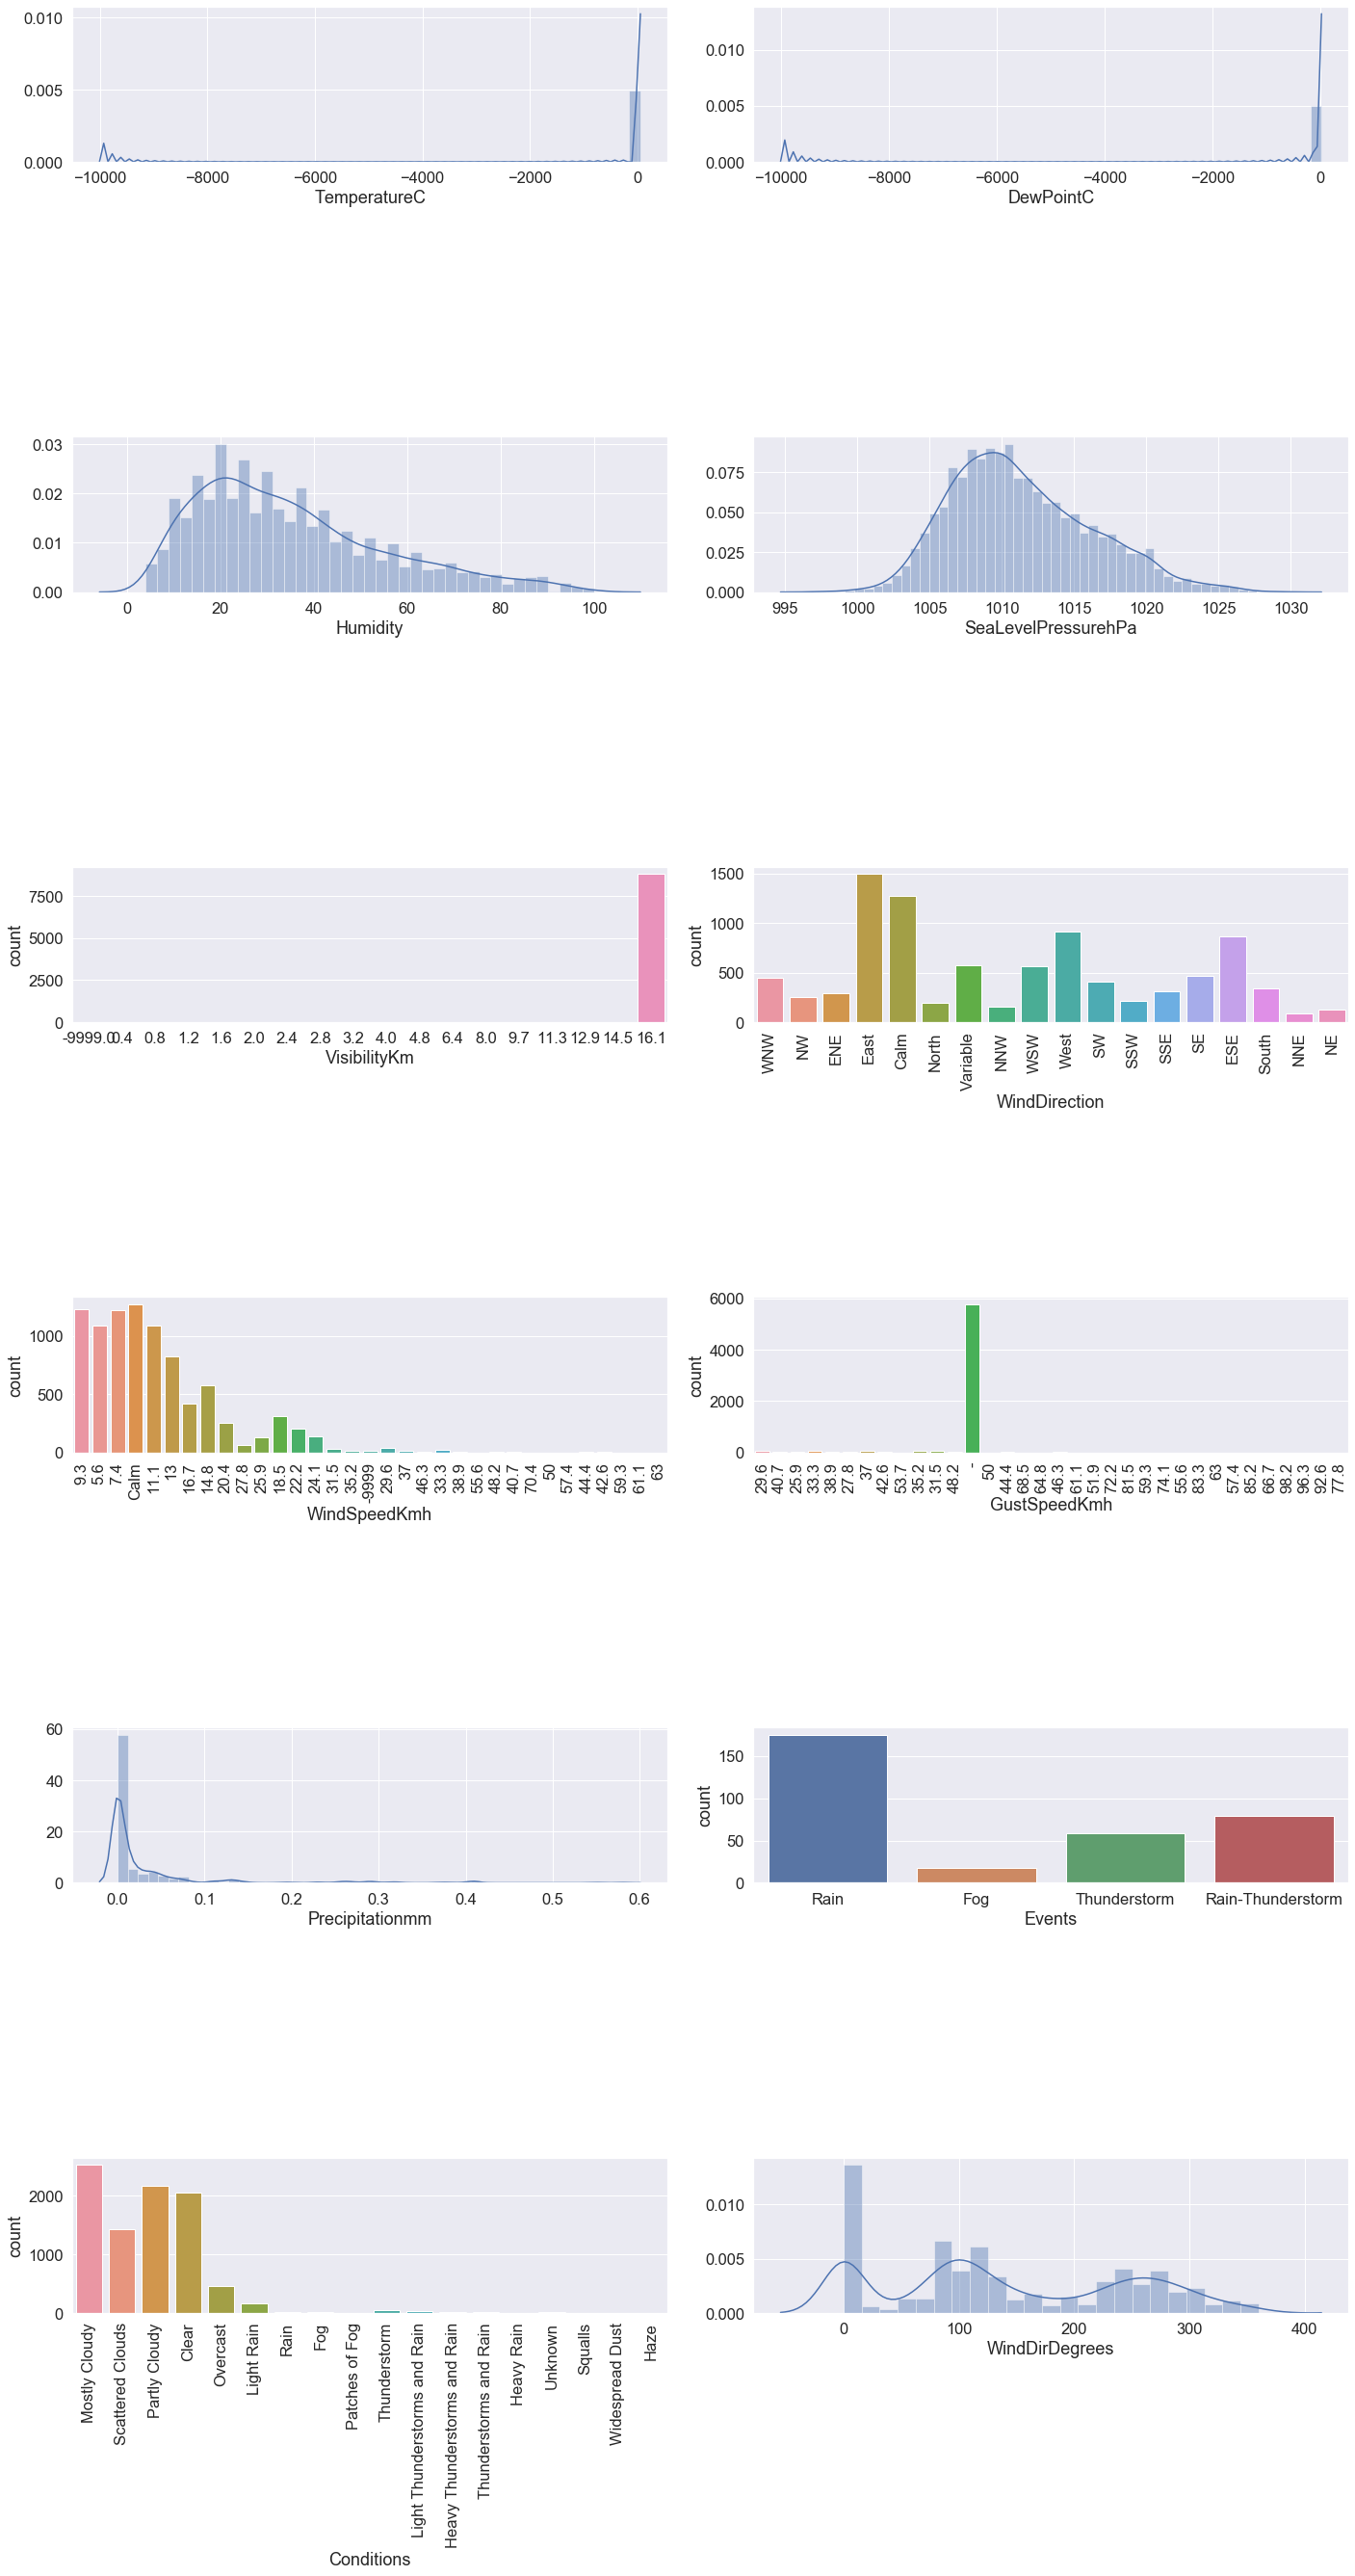

In [20]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
sns.distplot(df.TemperatureC)

plt.subplot(7,2,2)
sns.distplot(df.DewPointC)

plt.subplot(7,2,3)
sns.distplot(df.Humidity)

plt.subplot(7,2,4)
sns.distplot(df.SeaLevelPressurehPa)

plt.subplot(7,2,5)
sns.countplot(df.VisibilityKm)

plt.subplot(7,2,6)
plt.xticks(rotation = 90)
sns.countplot(df.WindDirection)

plt.subplot(7,2,7)
plt.xticks(rotation = 90)
sns.countplot(df.WindSpeedKmh)

plt.subplot(7,2,8)
plt.xticks(rotation = 90)
sns.countplot(df.GustSpeedKmh)

plt.subplot(7,2,9)
sns.distplot(df.Precipitationmm)

plt.subplot(7,2,10)
sns.countplot(df.Events)

plt.subplot(7,2,11)
plt.xticks(rotation = 90)
sns.countplot(df.Conditions)

plt.subplot(7,2,12)
sns.distplot(df.WindDirDegrees)

plt.tight_layout()
plt.show()

### Bivariate Data Exploration

In [21]:
# sns.jointplot(x='', y='',data=df, kind='scatter')

# sns.jointplot(x='', y='',data=df, kind='scatter')

# sns.jointplot(x='', y='',data=df, kind='scatter')

# sns.jointplot(x='', y='',data=df, kind='scatter')

# sns.jointplot(x='', y='',data=df, kind='kde')

# sns.jointplot(x='', y='',data=df, kind='kde')

# sns.jointplot(x='', y='',data=df, kind='hex')

# sns.jointplot(x='', y='',data=df, kind='hex')

# sns.jointplot(x='', y='',data=df, kind='reg')

# sns.jointplot(x='', y='',data=df, kind='reg')


# plt.show()

In [22]:
df.corr()

,TemperatureC,DewPointC,Humidity,SeaLevelPressurehPa,VisibilityKm,Precipitationmm,WindDirDegrees
TemperatureC,1.000000,0.999527,-0.586515,-0.027776,0.903748,0.101393,0.048506
DewPointC,0.999527,1.000000,0.454010,-0.016057,0.903964,0.265138,0.042153
Humidity,-0.586515,0.454010,1.000000,0.303535,-0.002870,0.134324,-0.168835
SeaLevelPressurehPa,-0.027776,-0.016057,0.303535,1.000000,-0.001960,0.023336,-0.267675
VisibilityKm,0.903748,0.903964,-0.002870,-0.001960,1.000000,-0.152096,0.046255
Precipitationmm,0.101393,0.265138,0.134324,0.023336,-0.152096,1.000000,0.020186
WindDirDegrees,0.048506,0.042153,-0.168835,-0.267675,0.046255,0.020186,1.000000


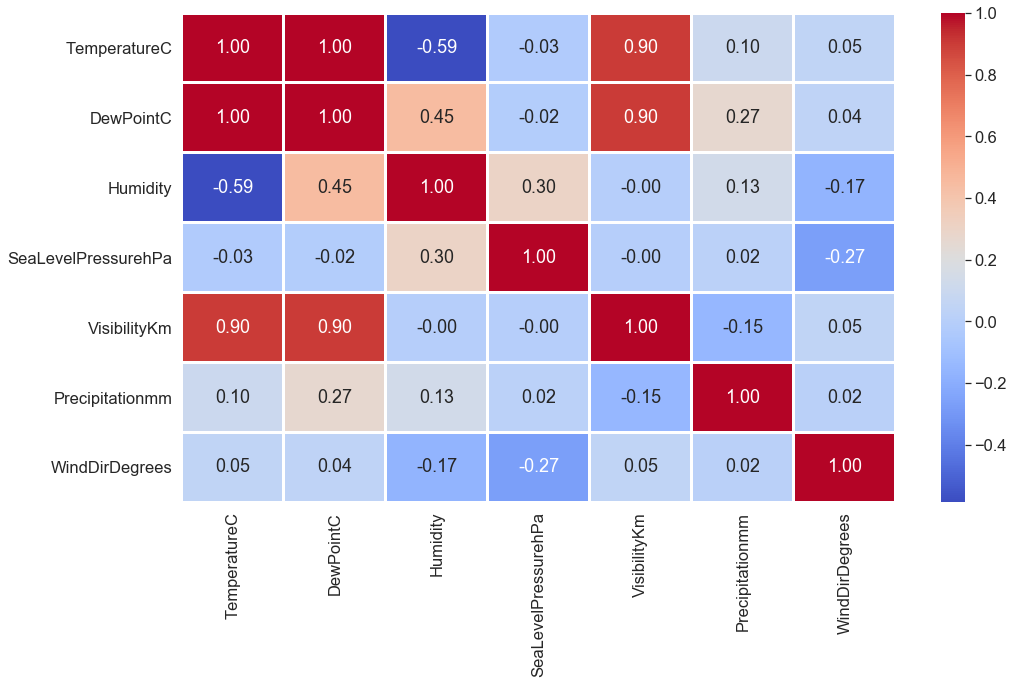

In [23]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

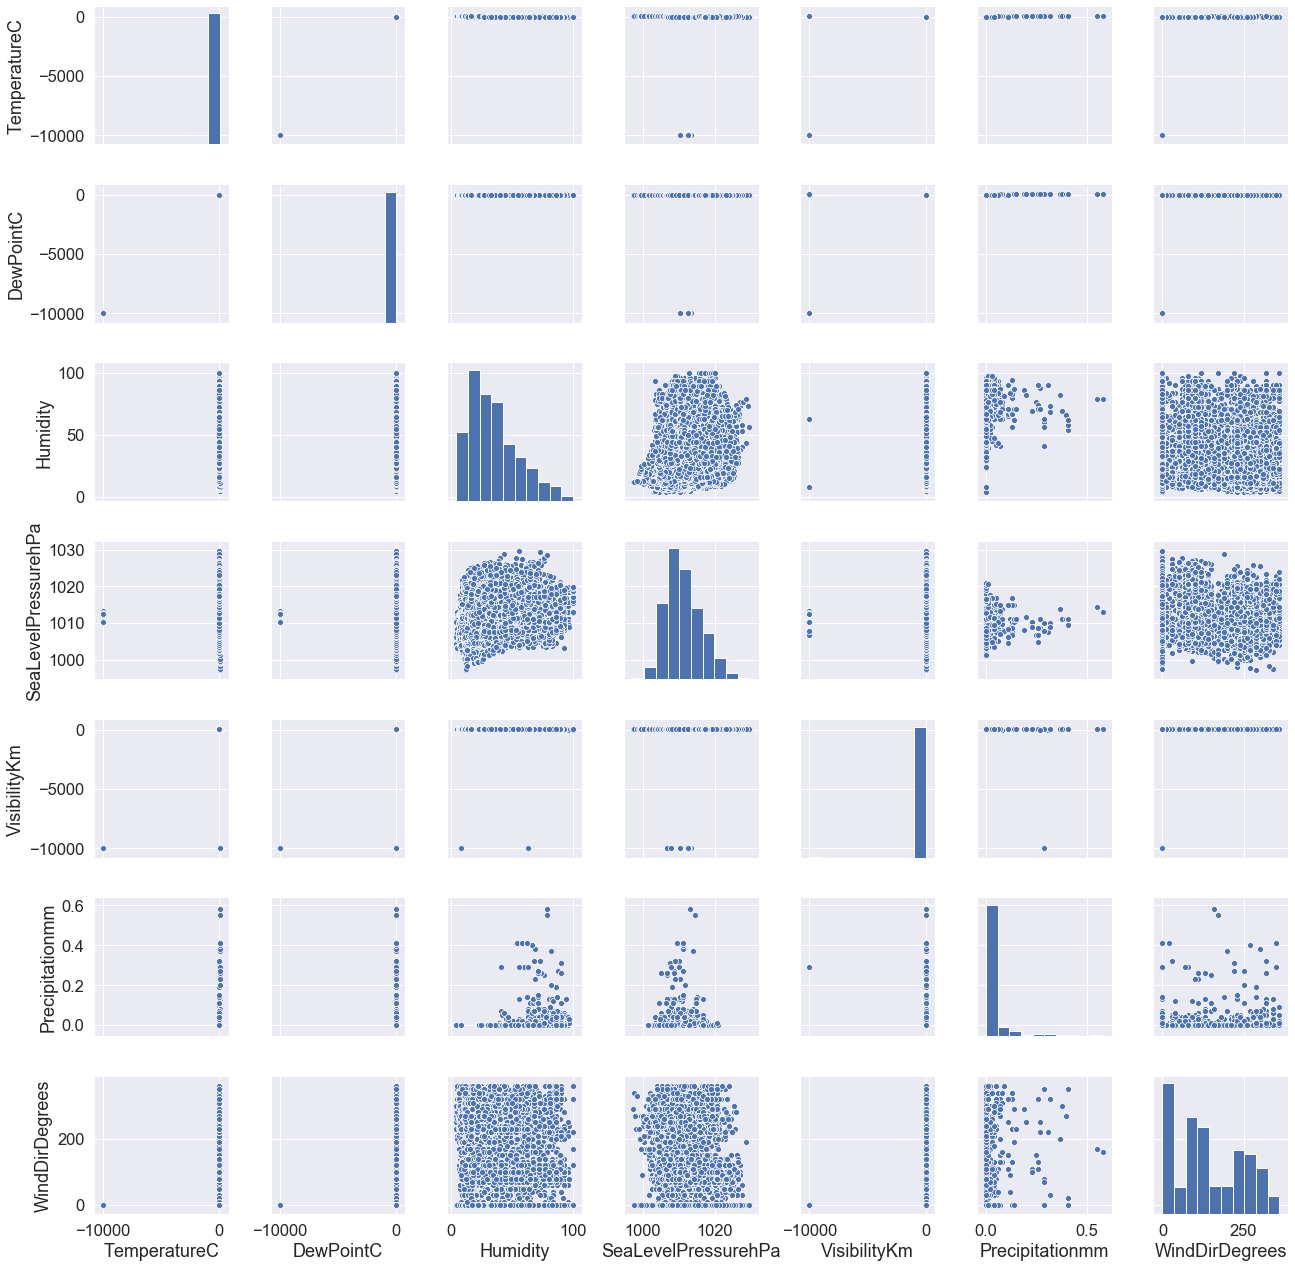

In [24]:
sns.pairplot(df)
plt.show()

### Data Preprocessing

### Treat Missing Values

In [25]:
df.isnull().sum()

TimeMST                   0
TemperatureC              0
DewPointC                 0
Humidity                  9
SeaLevelPressurehPa       0
VisibilityKm              0
WindDirection             0
WindSpeedKmh              0
GustSpeedKmh           2629
Precipitationmm        8556
Events                 8669
Conditions                0
WindDirDegrees            0
dtype: int64

In [26]:
#Drop columns
df.drop(['TimeMST','WindDirection','GustSpeedKmh','Precipitationmm','Events','Conditions'],axis=1,inplace=True)

In [27]:
df

,TemperatureC,DewPointC,Humidity,SeaLevelPressurehPa,VisibilityKm,WindSpeedKmh,WindDirDegrees
timestamp,,,,,,,
2015-01-01 00:51:00,2.8,-0.6,79.0,1016.0,16.1,9.3,300
2015-01-01 01:47:00,3.0,-1.0,75.0,1016.5,16.1,5.6,300
2015-01-01 01:51:00,2.8,-0.6,79.0,1016.9,16.1,7.4,300
2015-01-01 02:51:00,2.8,-1.1,76.0,1017.2,16.1,5.6,320
2015-01-01 03:51:00,2.2,-0.6,82.0,1017.5,16.1,5.6,60
...,...,...,...,...,...,...,...
2015-12-31 19:51:00,12.2,-6.1,28.0,1016.6,16.1,11.1,280
2015-12-31 20:51:00,11.7,-6.7,27.0,1017.0,16.1,11.1,270
2015-12-31 21:51:00,10.0,-6.7,31.0,1017.2,16.1,5.6,260


In [28]:
imputer = mdi.MeanMedianImputer(imputation_method='median',variables='Humidity')

In [29]:
imputer.fit(df)

MeanMedianImputer(imputation_method='median', variables=['Humidity'])

In [30]:
df = imputer.transform(df)

In [31]:
df.isnull().sum()

TemperatureC           0
DewPointC              0
Humidity               0
SeaLevelPressurehPa    0
VisibilityKm           0
WindSpeedKmh           0
WindDirDegrees         0
dtype: int64

### Treat Duplicate Values

In [32]:
#df.duplicated(keep='first').sum()

In [33]:
#df[df.duplicated(keep=False)]

In [34]:
#df.drop_duplicates(ignore_index=True, inplace=True)

### Replacing values

In [35]:
#df['TemperatureC'].replace(to_replace=-9999.0,value=0.0,inplace=True)

In [36]:
#df['DewPointC'].replace(to_replace=-9999.0,value=0.0,inplace=True)

In [37]:
#df['VisibilityKm'].replace(to_replace=-9999.0,value=0.0,inplace=True)

In [38]:
#df['WindSpeedKmh'].replace(to_replace='-9999',value=0.0,inplace=True)

In [39]:
df['WindSpeedKmh'].replace(to_replace="Calm",value=0.0,inplace=True)

In [40]:
df['WindSpeedKmh'].value_counts()

0.0      1268
9.3      1231
7.4      1218
11.1     1090
5.6      1087
13        823
14.8      573
16.7      417
18.5      315
20.4      257
22.2      201
24.1      135
25.9      130
27.8       67
29.6       42
31.5       30
33.3       25
-9999      19
35.2       15
37         13
38.9        9
48.2        5
44.4        5
40.7        5
46.3        4
42.6        3
70.4        2
63          2
57.4        2
61.1        2
59.3        2
50          1
55.6        1
Name: WindSpeedKmh, dtype: int64

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8999 entries, 2015-01-01 00:51:00 to 2015-12-31 23:51:00
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   TemperatureC         8999 non-null   float64
 1   DewPointC            8999 non-null   float64
 2   Humidity             8999 non-null   float64
 3   SeaLevelPressurehPa  8999 non-null   float64
 4   VisibilityKm         8999 non-null   float64
 5   WindSpeedKmh         8999 non-null   object 
 6   WindDirDegrees       8999 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 562.4+ KB


In [42]:
df['WindSpeedKmh'] = df['WindSpeedKmh'].astype("float64")

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8999 entries, 2015-01-01 00:51:00 to 2015-12-31 23:51:00
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   TemperatureC         8999 non-null   float64
 1   DewPointC            8999 non-null   float64
 2   Humidity             8999 non-null   float64
 3   SeaLevelPressurehPa  8999 non-null   float64
 4   VisibilityKm         8999 non-null   float64
 5   WindSpeedKmh         8999 non-null   float64
 6   WindDirDegrees       8999 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 562.4 KB


In [44]:
df1 = df[df['TemperatureC']>-9999]

In [45]:
df1

,TemperatureC,DewPointC,Humidity,SeaLevelPressurehPa,VisibilityKm,WindSpeedKmh,WindDirDegrees
timestamp,,,,,,,
2015-01-01 00:51:00,2.8,-0.6,79.0,1016.0,16.1,9.3,300
2015-01-01 01:47:00,3.0,-1.0,75.0,1016.5,16.1,5.6,300
2015-01-01 01:51:00,2.8,-0.6,79.0,1016.9,16.1,7.4,300
2015-01-01 02:51:00,2.8,-1.1,76.0,1017.2,16.1,5.6,320
2015-01-01 03:51:00,2.2,-0.6,82.0,1017.5,16.1,5.6,60
...,...,...,...,...,...,...,...
2015-12-31 19:51:00,12.2,-6.1,28.0,1016.6,16.1,11.1,280
2015-12-31 20:51:00,11.7,-6.7,27.0,1017.0,16.1,11.1,270
2015-12-31 21:51:00,10.0,-6.7,31.0,1017.2,16.1,5.6,260


In [46]:
df3 = df1.resample('H').sum()

In [47]:
df3

,TemperatureC,DewPointC,Humidity,SeaLevelPressurehPa,VisibilityKm,WindSpeedKmh,WindDirDegrees
timestamp,,,,,,,
2015-01-01 00:00:00,2.8,-0.6,79.0,1016.0,16.1,9.3,300
2015-01-01 01:00:00,5.8,-1.6,154.0,2033.4,32.2,13.0,600
2015-01-01 02:00:00,2.8,-1.1,76.0,1017.2,16.1,5.6,320
2015-01-01 03:00:00,2.2,-0.6,82.0,1017.5,16.1,5.6,60
2015-01-01 04:00:00,2.2,-1.1,79.0,1017.9,16.1,5.6,70
...,...,...,...,...,...,...,...
2015-12-31 19:00:00,12.2,-6.1,28.0,1016.6,16.1,11.1,280
2015-12-31 20:00:00,11.7,-6.7,27.0,1017.0,16.1,11.1,270
2015-12-31 21:00:00,10.0,-6.7,31.0,1017.2,16.1,5.6,260


### Merging with another dataset

In [48]:
df2 = pd.read_csv("Office_Autumn.csv", parse_dates=['timestamp'],index_col=['timestamp'])

In [49]:
df2

,Office_Autumn
timestamp,
2015-01-01 00:00:00,160.15
2015-01-01 01:00:00,162.95
2015-01-01 02:00:00,157.14
2015-01-01 03:00:00,266.57
2015-01-01 04:00:00,278.86
...,...
2015-12-31 19:00:00,171.21
2015-12-31 20:00:00,175.82
2015-12-31 21:00:00,47.28


In [50]:
df2.shape

(8760, 1)

In [51]:
df4 = pd.concat([df3,df2],axis=1)

In [52]:
df4

,TemperatureC,DewPointC,Humidity,SeaLevelPressurehPa,VisibilityKm,WindSpeedKmh,WindDirDegrees,Office_Autumn
timestamp,,,,,,,,
2015-01-01 00:00:00,2.8,-0.6,79.0,1016.0,16.1,9.3,300,160.15
2015-01-01 01:00:00,5.8,-1.6,154.0,2033.4,32.2,13.0,600,162.95
2015-01-01 02:00:00,2.8,-1.1,76.0,1017.2,16.1,5.6,320,157.14
2015-01-01 03:00:00,2.2,-0.6,82.0,1017.5,16.1,5.6,60,266.57
2015-01-01 04:00:00,2.2,-1.1,79.0,1017.9,16.1,5.6,70,278.86
...,...,...,...,...,...,...,...,...
2015-12-31 19:00:00,12.2,-6.1,28.0,1016.6,16.1,11.1,280,171.21
2015-12-31 20:00:00,11.7,-6.7,27.0,1017.0,16.1,11.1,270,175.82
2015-12-31 21:00:00,10.0,-6.7,31.0,1017.2,16.1,5.6,260,47.28


In [53]:
df4.isnull().sum()

TemperatureC           0
DewPointC              0
Humidity               0
SeaLevelPressurehPa    0
VisibilityKm           0
WindSpeedKmh           0
WindDirDegrees         0
Office_Autumn          0
dtype: int64

In [54]:
df4.describe()

,TemperatureC,DewPointC,Humidity,SeaLevelPressurehPa,VisibilityKm,WindSpeedKmh,WindDirDegrees,Office_Autumn
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,25.419932,5.860845,36.030479,1037.893402,14.053756,-0.581747,144.481735,146.462949
std,11.696066,9.357943,28.932416,267.443573,150.842184,337.734577,117.739996,53.143590
min,0.000000,-22.200000,0.000000,0.000000,-9999.000000,-9999.000000,0.000000,47.280000
25%,17.200000,-0.600000,19.000000,1007.800000,16.100000,5.600000,70.000000,106.420000
50%,25.000000,5.000000,31.000000,1010.700000,16.100000,9.300000,120.000000,133.440000
75%,32.200000,12.200000,46.000000,1014.900000,16.100000,13.000000,240.000000,197.760000
max,223.800000,129.900000,724.000000,8076.800000,103.200000,303.700000,1370.000000,303.320000


In [55]:
df4['VisibilityKm'].value_counts()

 16.1      8516
 32.2        89
 0.0         26
 14.5        14
 12.9        13
 48.3        12
 11.3         9
 9.7          8
 30.6         4
 6.4          3
 29.0         3
 24.1         3
 25.8         3
 8.0          3
 9.6          2
 40.2         2
 38.7         2
 64.4         2
 22.6         2
 1.2          2
 4.8          2
 0.8          2
 28.9         2
 41.9         2
 27.4         2
 28.6         1
 27.3         1
 24.2         1
 27.7         1
 74.8         1
 32.3         1
-9999.0       1
 24.0         1
 8.8          1
 64.0         1
 12.0         1
 16.0         1
 59.6         1
 4.0          1
 12.5         1
 103.2        1
 18.9         1
 23.3         1
 5.6          1
 33.8         1
 59.5         1
 2.4          1
 46.7         1
 24.2         1
 45.1         1
 18.0         1
 50.7         1
 35.5         1
-9931.4       1
 41.8         1
 27.3         1
 23.2         1
Name: VisibilityKm, dtype: int64

In [56]:
df4['VisibilityKm'].replace(to_replace=-9999.0,value=0.0,inplace=True)

In [57]:
df4['VisibilityKm'].replace(to_replace=-9931.4,value=0.0,inplace=True)

In [58]:
df4['VisibilityKm'].value_counts()

16.1     8516
32.2       89
0.0        28
14.5       14
12.9       13
48.3       12
11.3        9
9.7         8
30.6        4
6.4         3
29.0        3
24.1        3
25.8        3
8.0         3
9.6         2
40.2        2
38.7        2
64.4        2
22.6        2
1.2         2
4.8         2
0.8         2
28.9        2
41.9        2
27.4        2
28.6        1
27.3        1
24.2        1
27.7        1
74.8        1
32.3        1
24.0        1
8.8         1
64.0        1
12.0        1
16.0        1
59.6        1
4.0         1
12.5        1
103.2       1
18.9        1
23.3        1
5.6         1
33.8        1
59.5        1
2.4         1
46.7        1
24.2        1
45.1        1
18.0        1
50.7        1
35.5        1
41.8        1
27.3        1
23.2        1
Name: VisibilityKm, dtype: int64

In [59]:
df4['WindSpeedKmh'].value_counts()

0.0     1266
9.3     1201
7.4     1195
5.6     1066
11.1    1059
        ... 
74.0       1
77.8       1
72.3       1
68.6       1
55.6       1
Name: WindSpeedKmh, Length: 92, dtype: int64

In [60]:
df4['WindSpeedKmh'].replace(to_replace=-9999.0,value=0.0,inplace=True)

In [61]:
df4['WindSpeedKmh'].replace(to_replace=-9867.5,value=0.0,inplace=True)

In [62]:
df4['WindSpeedKmh'].value_counts()

0.0     1276
9.3     1201
7.4     1195
5.6     1066
11.1    1059
        ... 
74.0       1
77.8       1
72.3       1
68.6       1
55.6       1
Name: WindSpeedKmh, Length: 90, dtype: int64

### Create and save processed dataset

In [63]:
#df4.to_csv("energytrain.csv",index=False)

In [64]:
df4.shape

(8760, 8)

### Train Test Split

In [65]:
X = df4.iloc[:,0:7]
y = df4.iloc[:,7]

In [66]:
X.values, y.values

(array([[  2.8,  -0.6,  79. , ...,  16.1,   9.3, 300. ],
        [  5.8,  -1.6, 154. , ...,  32.2,  13. , 600. ],
        [  2.8,  -1.1,  76. , ...,  16.1,   5.6, 320. ],
        ...,
        [ 10. ,  -6.7,  31. , ...,  16.1,   5.6, 260. ],
        [  9.4,  -6.1,  33. , ...,  16.1,   0. ,   0. ],
        [  7.2,  -5.6,  40. , ...,  16.1,   0. ,   0. ]]),
 array([160.15, 162.95, 157.14, ...,  47.28, 187.35, 191.62]))

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [68]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7008, 7), (1752, 7), (7008,), (1752,))

### Feature Scaling

In [69]:
X_train

,TemperatureC,DewPointC,Humidity,SeaLevelPressurehPa,VisibilityKm,WindSpeedKmh,WindDirDegrees
timestamp,,,,,,,
2015-03-26 15:00:00,31.1,-8.9,7.0,1014.3,16.1,9.3,0
2015-10-01 18:00:00,17.2,6.1,48.0,1015.9,16.1,5.6,330
2015-09-23 11:00:00,31.1,15.0,37.0,1011.1,16.1,0.0,0
2015-05-26 10:00:00,30.0,4.4,20.0,1011.8,16.1,9.3,0
2015-11-17 20:00:00,12.2,1.1,47.0,1016.8,16.1,5.6,120
...,...,...,...,...,...,...,...
2015-07-02 05:00:00,12.2,6.1,66.0,1017.6,16.1,9.3,110
2015-11-25 19:00:00,19.4,3.3,34.0,1007.6,16.1,13.0,260
2015-07-22 11:00:00,36.7,5.6,15.0,1008.0,16.1,0.0,0


In [70]:
scaler = StandardScaler()

In [71]:
X_train_scaled = scaler.fit_transform(X_train)

In [72]:
X_test_scaled = scaler.transform(X_test)

In [73]:
X_train_scaled

array([[ 0.4753743 , -1.55663438, -0.98494833, ..., -0.08233086,
        -0.1516937 , -1.21849285],
       [-0.68980774,  0.02213765,  0.39798381, ..., -0.08233086,
        -0.5119407 ,  1.55391944],
       [ 0.4753743 ,  0.95887572,  0.02695324, ..., -0.08233086,
        -1.0571794 , -1.21849285],
       ...,
       [ 0.94480016, -0.03048808, -0.71510791, ..., -0.08233086,
        -1.0571794 , -1.21849285],
       [-0.40479918,  0.25369088,  0.29679366, ..., -0.08233086,
        -0.1516937 , -0.63040539],
       [-0.22038188,  0.25369088,  0.09441334, ..., -0.08233086,
        -0.5119407 ,  0.37774453]])

In [74]:
X_test_scaled

array([[ 0.56758295, -0.20941558, -0.64764781, ..., -0.08233086,
        -1.0571794 , -1.21849285],
       [ 0.24066137,  0.548395  , -0.07423692, ..., -0.08233086,
         0.3838086 , -0.5463929 ],
       [ 1.12921746, -0.38834308, -0.88375818, ..., -0.08233086,
         1.10430261,  0.96583199],
       ...,
       [-0.08626021, -0.09363896, -0.24288718, ..., -0.08233086,
        -0.3366854 , -1.05046786],
       [-0.87422504, -0.15678984,  0.43171387, ..., -0.08233086,
        -1.0571794 , -1.21849285],
       [-1.24305964, -0.15678984,  1.00512476, ..., -0.08233086,
        -1.0571794 , -1.21849285]])

In [75]:
y_train

timestamp
2015-03-26 15:00:00    209.40
2015-10-01 18:00:00    162.53
2015-09-23 11:00:00    211.70
2015-05-26 10:00:00    203.77
2015-11-17 20:00:00    184.91
                        ...  
2015-07-02 05:00:00    116.99
2015-11-25 19:00:00    152.40
2015-07-22 11:00:00    210.89
2015-05-17 00:00:00     63.58
2015-04-24 20:00:00    154.67
Name: Office_Autumn, Length: 7008, dtype: float64

In [76]:
y_test

timestamp
2015-06-19 03:00:00    131.88
2015-10-16 02:00:00     93.96
2015-01-10 17:00:00    112.03
2015-02-10 22:00:00    120.21
2015-09-06 15:00:00    122.94
                        ...  
2015-05-12 08:00:00    182.08
2015-09-02 11:00:00    214.71
2015-05-25 00:00:00     83.20
2015-11-19 22:00:00    124.99
2015-11-19 00:00:00    138.93
Name: Office_Autumn, Length: 1752, dtype: float64

### Model Training

### Using XGBoost (Scikit-Learn)

In [77]:
xgbmodel = XGBRegressor(random_state=0, n_estimators=400, objective='reg:squarederror')

In [78]:
xgbmodel.fit(X_train_scaled,y_train,eval_set=[(X_test_scaled,y_test)],eval_metric='rmse',early_stopping_rounds=10)

[0]	validation_0-rmse:141.123
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:128.971
[2]	validation_0-rmse:118.163
[3]	validation_0-rmse:108.63
[4]	validation_0-rmse:100.219
[5]	validation_0-rmse:92.8115
[6]	validation_0-rmse:86.4078
[7]	validation_0-rmse:80.8397
[8]	validation_0-rmse:75.9587
[9]	validation_0-rmse:71.8098
[10]	validation_0-rmse:68.1558
[11]	validation_0-rmse:65.1024
[12]	validation_0-rmse:62.4466
[13]	validation_0-rmse:60.1931
[14]	validation_0-rmse:58.2974
[15]	validation_0-rmse:56.7147
[16]	validation_0-rmse:55.3552
[17]	validation_0-rmse:54.226
[18]	validation_0-rmse:53.2804
[19]	validation_0-rmse:52.4974
[20]	validation_0-rmse:51.8868
[21]	validation_0-rmse:51.3449
[22]	validation_0-rmse:50.8977
[23]	validation_0-rmse:50.4786
[24]	validation_0-rmse:50.1596
[25]	validation_0-rmse:49.9005
[26]	validation_0-rmse:49.6744
[27]	validation_0-rmse:49.4752
[28]	validation_0-rmse:49.271
[29]	validation_0-rmse:49.1205
[30]	validation_0-

[259]	validation_0-rmse:46.0413
[260]	validation_0-rmse:46.0382
[261]	validation_0-rmse:46.0418
[262]	validation_0-rmse:46.039
[263]	validation_0-rmse:46.0347
[264]	validation_0-rmse:46.0309
[265]	validation_0-rmse:46.0255
[266]	validation_0-rmse:46.0237
[267]	validation_0-rmse:46.0029
[268]	validation_0-rmse:45.9974
[269]	validation_0-rmse:45.9966
[270]	validation_0-rmse:45.9931
[271]	validation_0-rmse:45.9781
[272]	validation_0-rmse:45.9776
[273]	validation_0-rmse:45.9765
[274]	validation_0-rmse:45.9791
[275]	validation_0-rmse:45.9754
[276]	validation_0-rmse:45.9724
[277]	validation_0-rmse:45.9752
[278]	validation_0-rmse:45.9807
[279]	validation_0-rmse:45.9879
[280]	validation_0-rmse:45.9835
[281]	validation_0-rmse:45.9676
[282]	validation_0-rmse:45.967
[283]	validation_0-rmse:45.968
[284]	validation_0-rmse:45.9603
[285]	validation_0-rmse:45.9433
[286]	validation_0-rmse:45.944
[287]	validation_0-rmse:45.942
[288]	validation_0-rmse:45.9424
[289]	validation_0-rmse:45.9316
[290]	validat

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=400,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [79]:
y_pred = xgbmodel.predict(X_test_scaled)

In [80]:
y_pred

array([126.672485, 120.96149 , 169.82594 , ..., 136.6906  , 118.688416,
       129.06006 ], dtype=float32)

### Model Evaluation

In [81]:
mse = mean_squared_error(y_test,y_pred)
mse

2094.6908685265234

In [82]:
rmse = np.sqrt(mse)
rmse

45.767792917361916

In [83]:
r2score = r2_score(y_test,y_pred)
r2score

0.2529035674584602

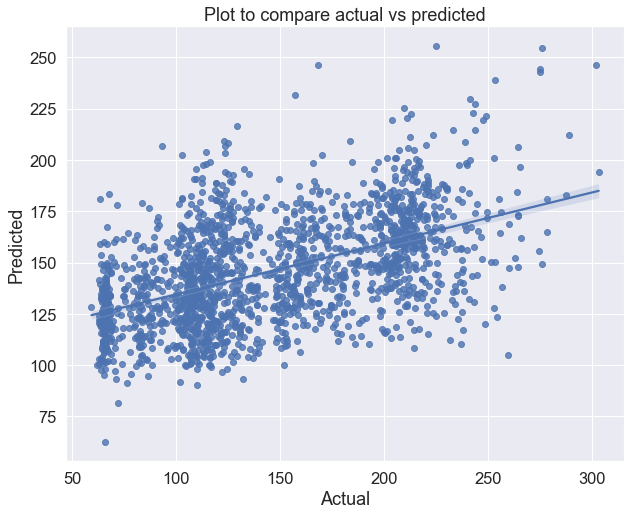

In [84]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=y_test, y=y_pred, ax=ax)
plt.title("Plot to compare actual vs predicted")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

In [85]:
X.columns

Index(['TemperatureC', 'DewPointC', 'Humidity', 'SeaLevelPressurehPa',
       'VisibilityKm', 'WindSpeedKmh', 'WindDirDegrees'],
      dtype='object')

In [86]:
xgbmodel.get_booster().feature_names = ['TemperatureC', 'DewPointC', 'Humidity', 'SeaLevelPressurehPa',
       'VisibilityKm', 'WindSpeedKmh', 'WindDirDegrees']

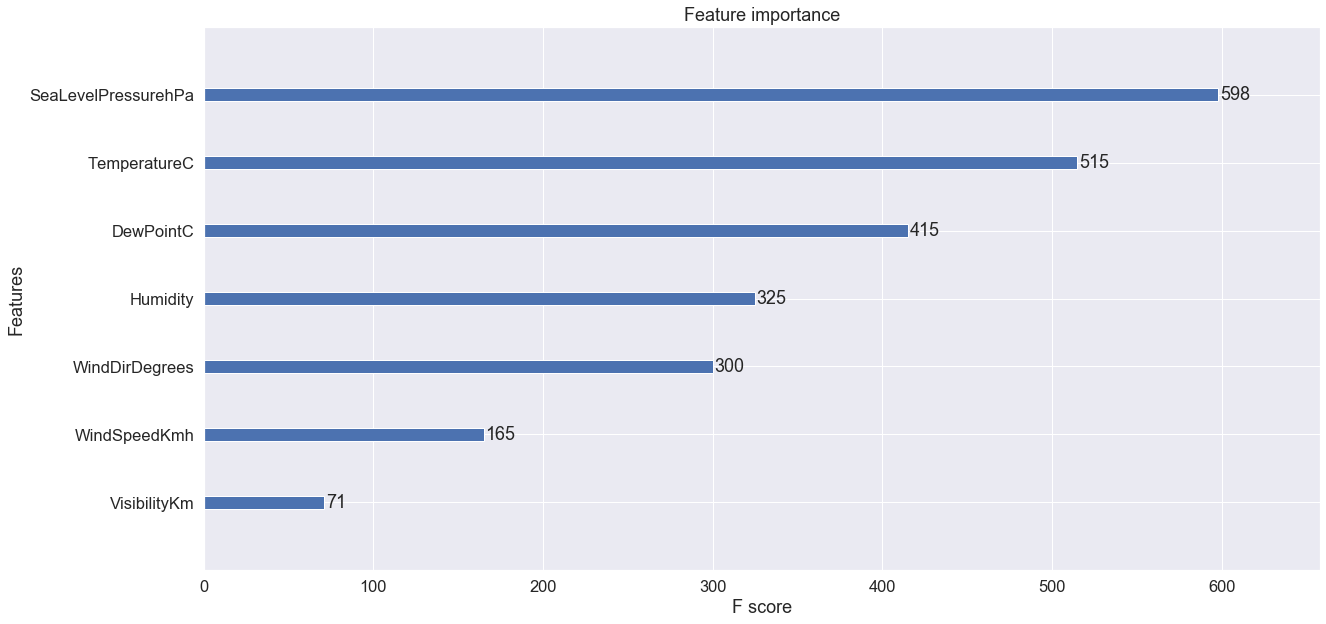

In [87]:
fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbmodel.get_booster(),ax=ax)
plt.show()

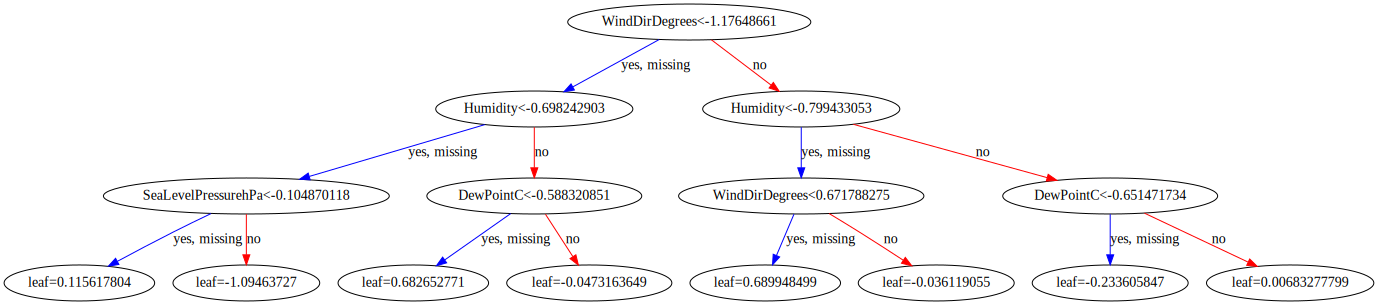

In [88]:
xgb.to_graphviz(xgbmodel,num_trees=300)

### Cross-Validation

In [89]:
cv = cross_val_score(xgbmodel,X,y,cv=5,verbose=1,scoring='neg_mean_squared_error')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.8s finished


In [90]:
cv.mean()

-2862.3210426304627

In [91]:
#sorted(sklearn.metrics.SCORERS.keys())

### Model Tuning

### Using RandomSearchCV

In [92]:
model = XGBRegressor(random_state=0, n_estimators=400, objective='reg:squarederror')

In [93]:
parameters = {'max_depth': np.arange(3,10,1),
              'learning rate': np.arange(0.05,0.3,0.03),
              'n_estimators':np.arange(100,1000,100),
              'min_child_weight': np.arange(1,4,1),
              'gamma':np.arange(0,50,2),
              'subsample':np.arange(0.5,0.9,0.1),
              'colsample_bytree':np.arange(0.5,0.9,0.1)
             }

In [94]:
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, cv = 5, n_iter = 50, 
                           n_jobs=-1, scoring='neg_mean_squared_error', random_state=0)

In [95]:
randm.fit(X, y)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=400,
                                          n_jobs=1, nthread=None,
                                          objective='reg:squarederror',
                                          random_state=0, reg_...
                                        'learning rate': array([0.05, 0.08, 0.11, 0.14, 0.17, 0.2 , 0.23, 0.26, 0.29]),
                                        'max_depth': array([3, 4, 5,

In [96]:
randm.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7999999999999999, gamma=24,
             importance_type='gain', learning rate=0.26, learning_rate=0.1,
             max_delta_step=0, max_depth=4, min_child_weight=3, missing=None,
             n_estimators=100, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.7999999999999999, verbosity=1)

In [97]:
randm.best_score_

-2862.9856067913947

In [98]:
randm.best_params_

{'subsample': 0.7999999999999999,
 'n_estimators': 100,
 'min_child_weight': 3,
 'max_depth': 4,
 'learning rate': 0.26,
 'gamma': 24,
 'colsample_bytree': 0.7999999999999999}

### Final Model

In [99]:
xgbnew = XGBRegressor(random_state=0, n_estimators=100, objective='reg:squarederror',max_depth=4,
                      gamma=24, min_child_weight=3,learning_rate=0.26,subsample=0.7999999999999999,colsample_bytree=0.7999999999999999)

In [100]:
xgbnew.fit(X_train_scaled,y_train,eval_set=[(X_test_scaled,y_test)],eval_metric='rmse',early_stopping_rounds=10)

[0]	validation_0-rmse:119.551
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:94.6691
[2]	validation_0-rmse:77.5665
[3]	validation_0-rmse:66.2694
[4]	validation_0-rmse:59.2058
[5]	validation_0-rmse:54.6843
[6]	validation_0-rmse:51.9726
[7]	validation_0-rmse:50.2208
[8]	validation_0-rmse:49.193
[9]	validation_0-rmse:48.6071
[10]	validation_0-rmse:48.2619
[11]	validation_0-rmse:48.0622
[12]	validation_0-rmse:47.9368
[13]	validation_0-rmse:47.8168
[14]	validation_0-rmse:47.7495
[15]	validation_0-rmse:47.6856
[16]	validation_0-rmse:47.6402
[17]	validation_0-rmse:47.5473
[18]	validation_0-rmse:47.4976
[19]	validation_0-rmse:47.3409
[20]	validation_0-rmse:47.3161
[21]	validation_0-rmse:47.2104
[22]	validation_0-rmse:47.2283
[23]	validation_0-rmse:47.1873
[24]	validation_0-rmse:47.206
[25]	validation_0-rmse:47.1818
[26]	validation_0-rmse:47.0628
[27]	validation_0-rmse:47.0247
[28]	validation_0-rmse:46.9714
[29]	validation_0-rmse:46.8981
[30]	validation_0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7999999999999999, gamma=24,
             importance_type='gain', learning_rate=0.26, max_delta_step=0,
             max_depth=4, min_child_weight=3, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.7999999999999999, verbosity=1)

In [101]:
y_pred = xgbnew.predict(X_test_scaled)

In [102]:
y_pred

array([120.3868  , 112.36738 , 165.32048 , ..., 131.15715 , 103.358444,
       119.99217 ], dtype=float32)

In [103]:
mse = mean_squared_error(y_test,y_pred)
mse

2085.7096950161845

In [104]:
rmse = np.sqrt(mse)
rmse

45.66957077766534

In [105]:
r2score = r2_score(y_test,y_pred)
r2score

0.2561068098988738

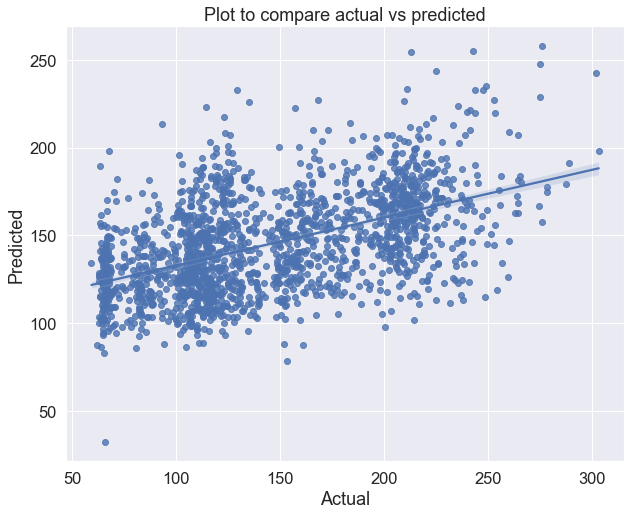

In [106]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=y_test, y=y_pred, ax=ax)
plt.title("Plot to compare actual vs predicted")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

### Save the Model

In [107]:
filename = 'modelenergy.sav'
dump(xgbnew,open(filename,'wb'))